In [30]:
import pandas as pd
from tqdm import tqdm
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [2]:
pd.options.plotting.backend = "matplotlib"

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
df_train.tail(20)

,id,keyword,location,text,target
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0
7594,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby ...,1
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1
7597,10852,NaN,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#df_train = df_train.dropna()

In [7]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<AxesSubplot:>

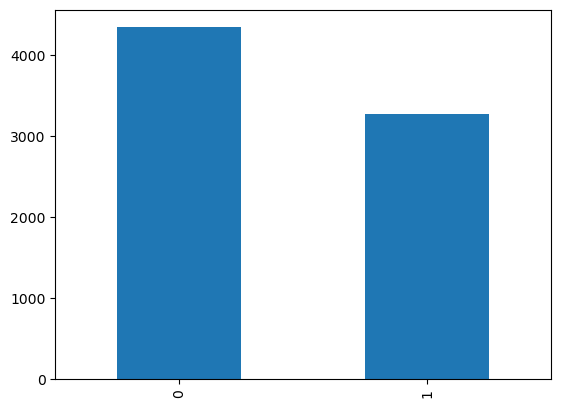

In [8]:
df_train.target.value_counts().plot(kind='bar')

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielroger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
snlp = spacy.load('en_core_web_sm')

In [11]:
def lemmatizer(text):
    result = [word.lemma_ for word in snlp(text)]
    return " ".join(result)

In [12]:
def preprocess(df):
    df['text_lemma'] = df.text.apply(lemmatizer)
    return df

In [13]:
stopwords = list(set(snlp.Defaults.stop_words).union(set(nltk.corpus.stopwords.words('english'))))

# Count Vectorizer

In [14]:
vec_model = CountVectorizer(stop_words=stopwords, ngram_range=(1,2))

In [15]:
df_train = preprocess(df_train)

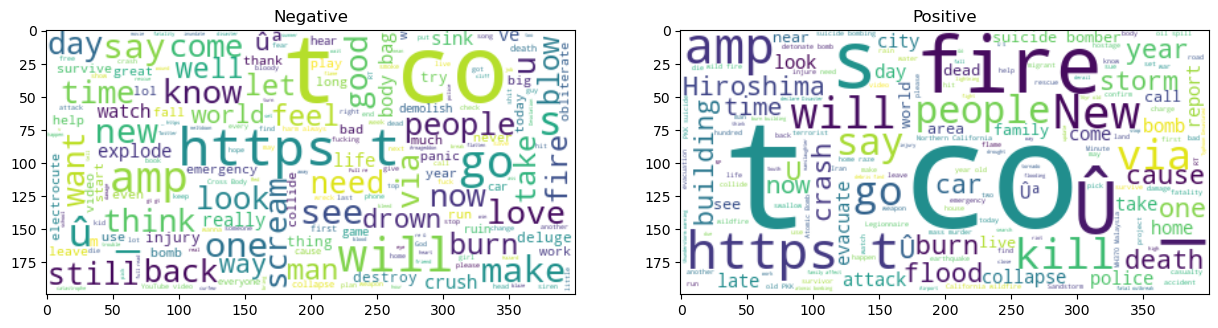

In [34]:
negative_cases = "".join(df_train[df_train['target'] == 0]['text_lemma'].values)
positive_cases = "".join(df_train[df_train['target'] == 1]['text_lemma'].values)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

In [16]:
vectors = vec_model.fit_transform(df_train.text_lemma)

In [17]:
X = vectors.toarray()
y = df_train['target'].values

In [18]:
#vec_model.vocabulary_

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5329, 70073), (2284, 70073), (5329,), (2284,))

# Random Forest

In [20]:
random_forest = RandomForestClassifier(random_state=42)

In [21]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = random_forest.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83      1318
           1       0.89      0.52      0.66       966

    accuracy                           0.77      2284
   macro avg       0.81      0.74      0.74      2284
weighted avg       0.80      0.77      0.76      2284



Text(50.722222222222214, 0.5, 'Valor Real')

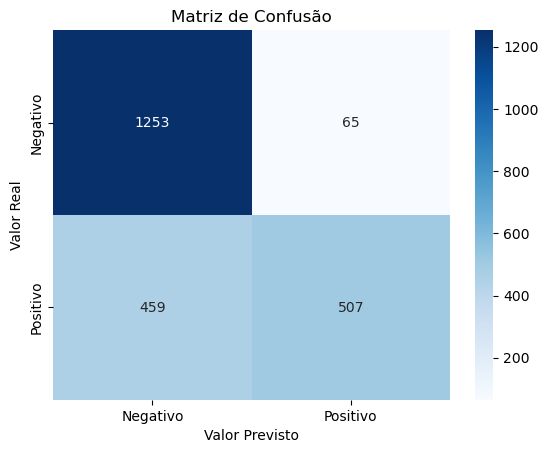

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cnf_matrix, annot=True, fmt='g', cmap=cmap, 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])

plt.title('Matriz de Confusão')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')

- 848 amostras foram classificadas corretamente como pertencentes à classe negativa (ou verdadeiros negativos).
- 36 amostras foram classificadas erroneamente como pertencentes à classe positiva, mas na verdade pertencem à classe negativa (ou falsos positivos).
- 304 amostras foram classificadas erroneamente como pertencentes à classe negativa, mas na verdade pertencem à classe positiva (ou falsos negativos).
- 336 amostras foram classificadas corretamente como pertencentes à classe positiva (ou verdadeiros positivos).

# Submit dataset

In [25]:
df_new = pd.DataFrame()
df_new['id'] = df_test['id']
vectors_test = vec_model.transform(df_test['text'])
df_new['target'] = random_forest.predict(vectors_test)

In [26]:
df_new

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


<AxesSubplot:>

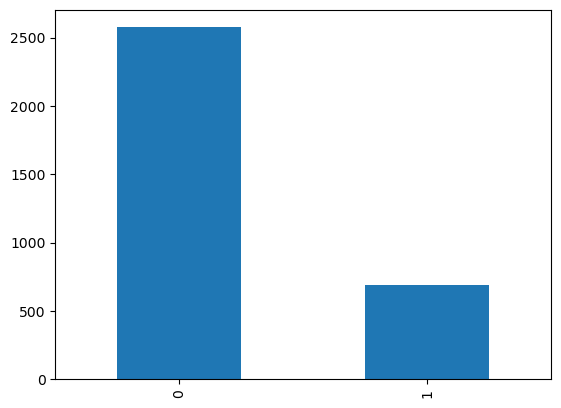

In [27]:
df_new.target.value_counts().plot(kind='bar')

In [39]:
df_new.shape

(3263, 2)

In [37]:
df_test2 = df_test.merge(df_new)

In [41]:
df_test2.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


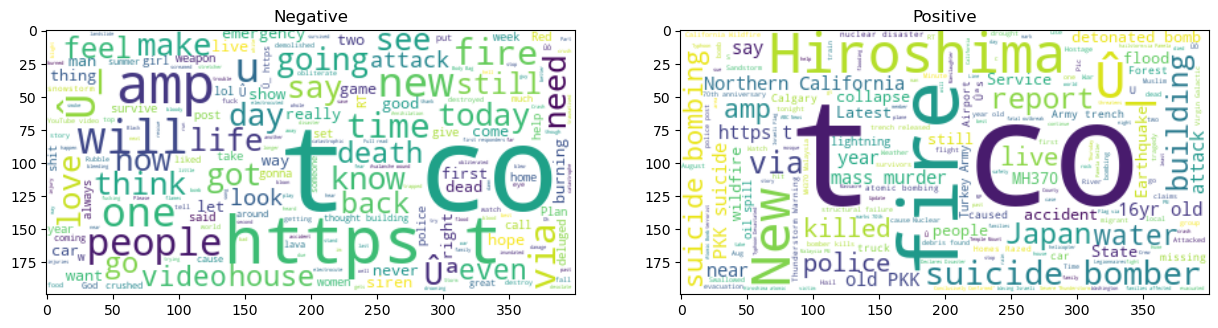

In [42]:
negative_cases = "".join(df_test2[df_test2['target'] == 0]['text'].values)
positive_cases = "".join(df_test2[df_test2['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()